# Distortion correction of fMRI data using field maps
Lennart Wittkuhn, 2019

## Import relevant packages
First, we load all relevant packages. Note: In order to use the BIDSDataGrabber interface you need to install pybids using pip install pybids.

In [4]:
import os
import sys
from IPython.display import display, Image
from bids.layout import BIDSLayout
from nipype.interfaces.io import BIDSDataGrabber
from nipype.pipeline.engine import Workflow, Node, MapNode, JoinNode
from nipype.interfaces.utility import IdentityInterface, Function, Select
from nipype.interfaces.io import SelectFiles, DataSink, JSONFileGrabber
from nipype.interfaces.fsl import SliceTimer
from nilearn import image
from nipype.interfaces.fsl import ExtractROI
from nipype.interfaces.fsl import Merge
from nipype.interfaces.fsl import TOPUP

# Geometric or intesity distortions due to field inhomogenities

* Functional images suffer from **geometric or intensity distortions**
* Most common cause: **magnetic field inhomogeneities**
* Inhomogeneities usually **most pronounced in the sinuses and auditory canals** (due to different tissues, e.g., air, bones)

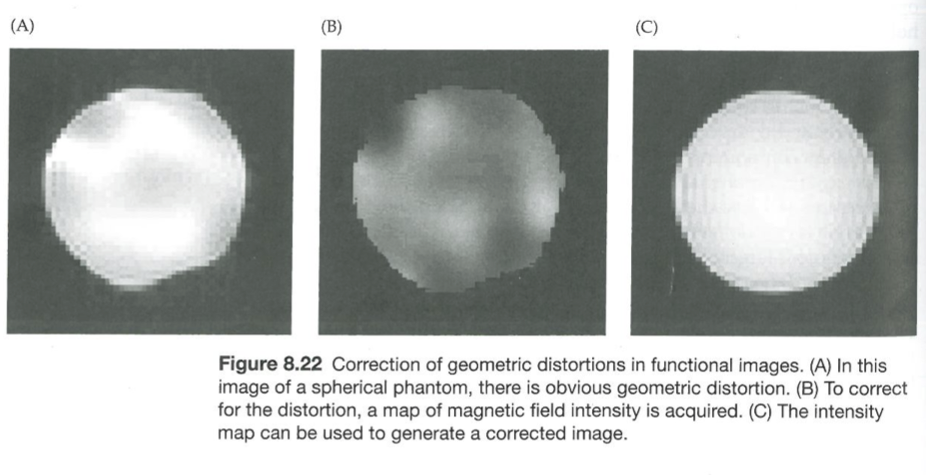

In [30]:
path_root = os.path.abspath(os.path.join(os.getcwd(),".."))
display(Image(filename= os.path.join(path_root, 'images', 'huettel_distortion.png')))

## How can we account for non-uniformity in the magnetic field?

1. **Magnetic field shimming (during scanning)**
 * By adjusting magnetic field gradients, usually a reasonably homogenous field can be created
 * But: Residual inhomgeneities may still induce distortions!


2. **Magnetic field mapping**
 * **Goal:** Acquire specific knowledge of the static magnetic field
 * **Method 1 (gradient double echo field map correction):** Calculate a field map based on a double-echo gradient sequence
 * **Method 2 (blip-up blip-down field map correction):** Calculate a field map based on two (or more) separate acquisitions with opposite phase encoding directions

3. **Bias field estimation (when field maps are not available)**

 * Estimate a map of intensity variations across space (i.e,. the bia field) using the distorted image itself (by making assumptions about the properties of noise, etc.)
    

## Define input and output paths

In [31]:
# define the root directory:
path_root = os.path.join('/Volumes', 'fMRIdatameeting')
# define the data target directory:
path_source = os.path.join(path_root, 'data')
# define the data target directory:
path_target = os.path.join(path_root, 'derivatives')

## Our data
If you have decided to use Brain Imaging Data Structure (BIDS) to organize your data (or got your hands on a BIDS dataset) you can take advantage of a formal structure BIDS imposes. To begin working with pybids we need to initialize a layout object. We will need it to do all of our queries. For example, we can figure out what the subject labels in this dataset are.

In [32]:
# get the structure of the bids dataset
layout = BIDSLayout(path_source)
# get a list of all subjects
subject_list = layout.get_subjects()
print(subject_list)
# get a list of all sessions
session_list = layout.get_sessions()
print(session_list)
# pint all modalities
print(layout.get_modalities())

/Users/wittkuhn/.virtualenvs/mri-preprocessing/lib/python3.7/site-packages/bids/layout/bids_layout.py:121: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Volumes/fMRIdatameeting/data/dataset_description.json' mode='r' encoding='UTF-8'>
  self.description = json.load(open(target, 'r'))
/Users/wittkuhn/.virtualenvs/mri-preprocessing/lib/python3.7/site-packages/grabbit/core.py:436: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/wittkuhn/.virtualenvs/mri-preprocessing/lib/python3.7/site-packages/bids/layout/config/bids.json' mode='r' encoding='UTF-8'>
  domain = json.load(open(domain, 'r'))


['01', '02']
['01', '02']
['anat', 'fmap', 'func']


## Define the workflow

In [35]:
# define the name of the workflow:
wf = Workflow(name="distortion_correction")
# stop execution of the workflow if an error is encountered:
wf.config = {'execution': {'stop_on_first_crash': True}}
# define the data target directory:
wf.base_dir = path_target

## Input stream: BIDSDataGrabber
The `BIDSDataGrabber` Node is including pybids in your nipype workflow. We want to include the BIDS layout into our nipype workflows. To do this, we can import `BIDSDataGrabber`, which provides an interface for BIDSLayout.get. We can define static filters, that will apply to all queries, by modifying the appropriate input.

In [36]:
# NODE: NIPYPE BIDS DATA GRABBER
# function: allows arbitrary querying of BIDS datasets
bg = Node(interface=BIDSDataGrabber(), name ="bidsdatagrabber")
# input: variables to iterate over
bg.iterables = [('subject',subject_list),('session',session_list)]
# input: define path to the BIDS directory (an existing directory name):
bg.inputs.base_dir = path_source
# input: define queries for outfield outputs:
bg.inputs.output_query['fmap_nii'] = dict(
    reconstruction='prenorm', modality='fmap', type='epi',
    extensions='nii.gz', dir=('AP', 'PA'))
bg.inputs.output_query['fmap_json'] = dict(
    reconstruction='prenorm', modality='fmap', type='epi', extensions='json')
bg.inputs.output_query['func_nii'] = dict(
    reconstruction='prenorm',
    task='highspeed', type='bold', extensions='nii.gz')
bg.inputs.output_query['func_json'] = dict(
    reconstruction='prenorm',
    task='highspeed', type='bold', extensions='json')

/Users/wittkuhn/.virtualenvs/mri-preprocessing/lib/python3.7/site-packages/nipype/interfaces/io.py:2796: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/wittkuhn/.virtualenvs/mri-preprocessing/lib/python3.7/site-packages/bids/layout/config/bids.json' mode='r' encoding='UTF-8'>
  bids_config = json.load(open(bids_config, 'r'))


In [37]:
bg.inputs.subject = "01"
bg.inputs.session = "01"
bg_results = bg.run()
bg_results.outputs

190109-11:13:33,275 nipype.workflow INFO:
	 [Node] Setting-up "bidsdatagrabber" in "/private/var/folders/d8/k32s9rs5507c1986nj3w8585n28cb5/T/tmpr6sh47io/bidsdatagrabber".
190109-11:13:33,288 nipype.workflow INFO:
	 [Node] Running "bidsdatagrabber" ("nipype.interfaces.io.BIDSDataGrabber")


/Users/wittkuhn/.virtualenvs/mri-preprocessing/lib/python3.7/site-packages/bids/layout/bids_layout.py:121: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Volumes/fMRIdatameeting/data/dataset_description.json' mode='r' encoding='UTF-8'>
  self.description = json.load(open(target, 'r'))
/Users/wittkuhn/.virtualenvs/mri-preprocessing/lib/python3.7/site-packages/grabbit/core.py:436: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/wittkuhn/.virtualenvs/mri-preprocessing/lib/python3.7/site-packages/bids/layout/config/bids.json' mode='r' encoding='UTF-8'>
  domain = json.load(open(domain, 'r'))


190109-11:13:33,645 nipype.workflow INFO:
	 [Node] Finished "bidsdatagrabber".



anat = ['/Volumes/fMRIdatameeting/data/sub-01/ses-01/anat/sub-01_ses-01_rec-prenorm_T1w.nii.gz']
fmap_json = ['/Volumes/fMRIdatameeting/data/sub-01/ses-01/fmap/sub-01_ses-01_rec-prenorm_dir-AP_epi.json', '/Volumes/fMRIdatameeting/data/sub-01/ses-01/fmap/sub-01_ses-01_rec-prenorm_dir-PA_epi.json']
fmap_nii = ['/Volumes/fMRIdatameeting/data/sub-01/ses-01/fmap/sub-01_ses-01_rec-prenorm_dir-AP_epi.nii.gz', '/Volumes/fMRIdatameeting/data/sub-01/ses-01/fmap/sub-01_ses-01_rec-prenorm_dir-PA_epi.nii.gz']
func = ['/Volumes/fMRIdatameeting/data/sub-01/ses-01/func/sub-01_ses-01_task-highspeed_rec-prenorm_run-01_bold.nii.gz', '/Volumes/fMRIdatameeting/data/sub-01/ses-01/func/sub-01_ses-01_task-highspeed_rec-prenorm_run-02_bold.nii.gz', '/Volumes/fMRIdatameeting/data/sub-01/ses-01/func/sub-01_ses-01_task-highspeed_rec-prenorm_run-03_bold.nii.gz', '/Volumes/fMRIdatameeting/data/sub-01/ses-01/func/sub-01_ses-01_task-highspeed_rec-prenorm_run-04_bold.nii.gz', '/Volumes/fMRIdatameeting/data/sub-01/ses

## Output stream: Datasink
A workflow working directory is like a cache. It contains not only the outputs of various processing stages, it also contains various extraneous information such as execution reports, hashfiles determining the input state of processes. All of this is embedded in a hierarchical structure that reflects the iterables that have been used in the workflow. This makes navigating the working directory a not so pleasant experience. And typically the user is interested in preserving only a small percentage of these outputs. The `DataSink` interface can be used to extract components from this cache and store it at a different location.

In [441]:
# create a node of the function:
datasink = Node(DataSink(), name='datasink')
# assign the path to the base directory:
datasink.inputs.base_directory = os.path.join(path_target)
# add "results"-string to the workflow name:
datasink.inputs.container = wf.name + '_results'
# do not store output in parametrized structure:
datasink.inputs.parameterization = False
# create a list of substitutions to adjust the filepaths of datasink:
substitutions = [("_session_id_", ""),("_subject_id_", "")]
# assign the substitutions to the datasink command:
datasink.inputs.substitutions = substitutions

## Method 2: Blip-up blip-down field map correction

### Introduction
* Method 2 uses two (or more) **separate acquisitions with opposite phase encoding directions** (blip-up and blip-down) to calculate a field map based on the difference in distortion between the two
* For BOLD EPI, you would collect opposing spin echo images
* For diffusion MRI, you would collect opposing B0 images.
* You must use an FSL tool (topup) to generate the field map and magnitude volumes from the opposing images you collect at the scanner.
* A [recent HBM poster by Fritz et al.](http://support.brainvoyager.com/documents/Company_Contact/Poster_FritzEtAl_HBM14.pdf) compared different distortion correction methods and found Method 2 consistently outperformed Method 1 (see plots below)
* Also, if you use **multi-band imaging**, the Human Connectome Project recommends Method 2, as it
> "[...] corrects for z gradient distortions prevalent in multi-band imaging"

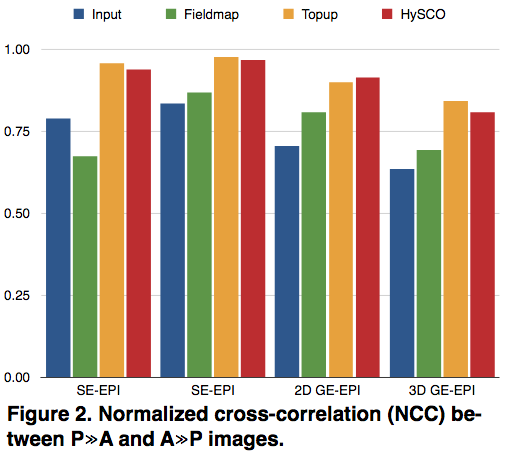

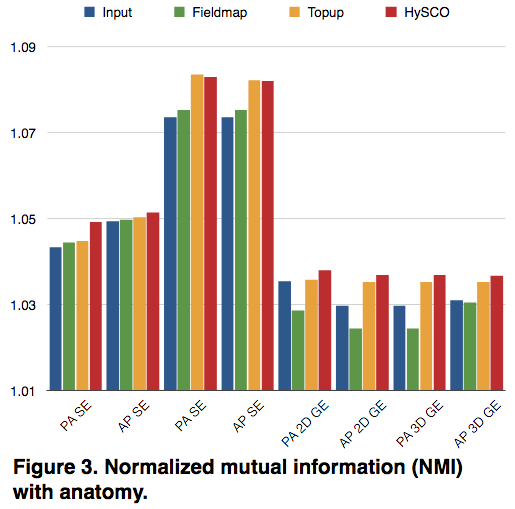

In [442]:
display(Image(filename='images/fritz_etal_figure2.png'))
display(Image(filename='images/fritz_etal_figure3.png'))

### Implementation at the MRI scanner
* Method 2 can be used with regular or multi-band BOLD EPI and diffusion EPI.
* The example in this tutorial will be for correcting BOLD data, but the principles are the same for diffusion data.
* If you use the UMinn CMRR multi-band BOLD EPI sequence, then it is recommended that you use the spin echo sequence that they provide.
* If you use the Siemens product BOLD EPI sequences (regular or multi-band), then you should stick with the Siemens product spin echo sequence.
* The most common way to implement this method is to **collect all of your BOLD EPI data in one phase-encode (PE) direction (typically A-P for transverse oriented slices), and collect a series of spin echo (SE) scans with opposing PE directions (typically A-P and P-A)**.
* You will improve the shape of the brain for better registration and stretched signal will be put back into the correct place.
* Note that, just like Method 1 (gradient double echo field map), you will not retrieve signal that is compressed or occluded by susceptibility-induced signal void.
* The sequence pairs must be acquired in the same scan session as the BOLD runs
* No re-shimming can be done
* Copy the same slice position and adjustment (i.e., shim) volume from your BOLD runs
* Try to collect an even number of slices, otherwise you need off the top or bottom slice of everything during (FSL) preprocessing

* The most common way to implement this method is to collect all of your BOLD data in one phase-encode (PE) direction (typically A-P for transverse oriented slices), and collect a series of spin echo (SE) scans with opposing PE directions (typically A-P and P-A).
* You will improve the shape of the brain for better registration and stretched signal will be put back into the correct place.
* Note that, just like Method 1 (gradient double echo field map), you will not retrieve signal that is compressed or occluded by susceptibility-induced signal void.

### Required software
The FSL tool `topup` is currently the **only** tool available to calculate a field map and magnitude image from blip-up and blip-down images. Once those images are created, you may apply them to your BOLD EPI data using the field map correction software tool of your choice (e.g., SPM, FSL, BrainVoyager). Please see the [official FSL documentation of topup](http://fsl.fmrib.ox.ac.uk/fsl/fslwiki/TOPUP) for more details.

### How to run `topup` in a `nipype` workflow

#### Define node: `Select`
* In order to late run `topup` we need to obtain important information about our field map acquisitions from the `.json`-files in our `BIDS`-valid data set.
* The `Select` function is a basic nipype interface class to select specific elements from a list.
* Here, we use `Select` to select only the first `.json`-file of the field map `.json`-files
* Note, that for each subject and session, we have one `.json`-file for each corresponding phase-encoding direction (AP and PA, respectively).

In [443]:
# DEFINE NODE: SELECT
# function: create a selection node that selects the first element
select_fmap = Node(interface=Select(), name="select_fmap")
# input: 0-based indices of values to choose:
select_fmap.inputs.index = 0

In [444]:
# CONNECT NODE: BIDSDATAGRABBER NODE TO SELECT NODE:
# input: all fieldmap json files
wf.connect(bg, 'fmap_json', select_fmap, 'inlist')

In [445]:
select_fmap.inputs.inlist = bg_results.outputs.fmap_json
select_fmap_results = select_fmap.run()
select_fmap_results.outputs

190108-17:48:23,807 nipype.workflow INFO:
	 [Node] Setting-up "distortion_correction.select_fmap" in "/private/var/folders/d8/k32s9rs5507c1986nj3w8585n28cb5/T/tmpjkuj_nk9/distortion_correction/select_fmap".
190108-17:48:23,812 nipype.workflow INFO:
	 [Node] Running "select_fmap" ("nipype.interfaces.utility.base.Select")
190108-17:48:23,820 nipype.workflow INFO:
	 [Node] Finished "distortion_correction.select_fmap".



out = /Volumes/fMRIdatameeting/data/sub-01/ses-01/fmap/sub-01_ses-01_rec-prenorm_dir-AP_epi.json

#### Define node: JSONFileGrabber
* In order to be able to read the acquisition information from the `.json`-file we need to create a node using the `JSONFileGrabber` interface.
* The `JSONFileGrabber` is a Datagrabber interface that loads a `.json`-file and generates an output for every first-level object.
* Here, we only load the single `.json`-file selected by the `Select` node defined above.

In [446]:
# DEFINE NODE: JSONFILEGRABBER (DATAGRABBER INTERFACE)
# function: loads json file and generates output for first-level object
json_fmap = Node(interface=JSONFileGrabber(), name="json_fmap")

In [447]:
# CONNECT NODE: SELECT NODE TO JSONFILEGRABBER NODE (DATAGRABBER INTERFACE)
# input: list of values to choose from (here, list of fielmap json files):
wf.connect(select_fmap, 'out', json_fmap, 'in_file')

In [448]:
# input: JSON source file (an existing file name)
json_fmap.inputs.in_file = select_fmap_results.outputs.out
# output: list of acquisition information from the json file (example)
json_fmap_results = json_fmap.run()
json_fmap_results.outputs

190108-17:48:23,863 nipype.workflow INFO:
	 [Node] Setting-up "distortion_correction.json_fmap" in "/private/var/folders/d8/k32s9rs5507c1986nj3w8585n28cb5/T/tmp7yecl6fa/distortion_correction/json_fmap".
190108-17:48:23,870 nipype.workflow INFO:
	 [Node] Running "json_fmap" ("nipype.interfaces.io.JSONFileGrabber")
190108-17:48:23,902 nipype.workflow INFO:
	 [Node] Finished "distortion_correction.json_fmap".



AcquisitionMatrixPE = 96
AcquisitionNumber = 1
AcquisitionTime = 14:04:13.025000
BandwidthPerPixelPhaseEncode = 13.706
BaseResolution = 96
ConversionSoftware = dcm2niix
ConversionSoftwareVersion = v1.0.20180328 Clang9.0.0
DerivedVendorReportedEchoSpacing = 0.000760008
DeviceSerialNumber = 35453
DwellTime = 3.3e-06
EchoTime = 0.026
EffectiveEchoSpacing = 0.000760008
FlipAngle = 71
ImageComments = Unaliased_MB4_PE3_LB
ImageOrientationPatientDICOM = [0.999328, -0.0050365, 0.0362959, 2.14969e-08, 0.990509, 0.137445]
ImageType = ['ORIGINAL', 'PRIMARY', 'M', 'MB', 'ND', 'NORM', 'MOSAIC']
InPlanePhaseEncodingDirectionDICOM = COL
InstitutionAddress = Lentzallee_94_Berlin_District_DE_14195
InstitutionName = MPI_for_Human_Development
InstitutionalDepartmentName = Department
IntendedFor = ['ses-01/func/sub-01_ses-01_task-highspeed_rec-prenorm_run-01_bold.nii.gz', 'ses-01/func/sub-01_ses-01_task-highspeed_rec-prenorm_run-02_bold.nii.gz', 'ses-01/func/sub-01_ses-01_task-highspeed_rec-prenorm_run-0

#### Define node `fslroi`: Only select the first volume of each field map acquisition (optional!)
* Usually, several volumes (e.g., 5 to 6) are aquired for the blip-up and blip-down images.
* Of course, this depends on how many volumes were acquired in the respective field map acquisitions.
* Looking at the `dcmmeta_shape` field in the `.json`-file above, we can see that 6 volumes have been acquired in this example. 
* It is possible to create the fieldmap only based on the data from one volume for each phase-encoding direction.
* However, the estimation of the B0-inhomogenities might be more accurate if data from multiple volumes is considered (and averaged during the top-up process).
* If you just want to test a processing scripts, it is fine to only select one volume from each sequence e.g., using FLS's `fslroi` command.
* This step reduces the computation time of the `topup` command considerably.
* However, if computation time does not matter so much (e.g., when you are running your script on a cluster) it may be recommended to use all of the acquired volumes (you have the data anyway, right!)
* Generally, the `fslroi` command is used to extract a region of interest (ROI) from an image.
* Here, we want to use it to extract just some time points from a 4D data set (our two fieldmap acquisitions)
* Note that the arguments are minimum index and size (not maximum index).
* So to extract voxels 10 to 12 inclusive you would specify 10 and 3 (not 10 and 12).

In [449]:
# define the number of volumes to be extracted from each acquisition
num_vol = 1

In [450]:
# NODE: FSL ROI
# function: extract region of interest (ROI) from an image
roi_fmap = MapNode(ExtractROI(), name='roi_fmap', iterfield=['in_file'])
# input: define the fsl output type:
roi_fmap.inputs.output_type = 'NIFTI_GZ'
# input: define index of the first selected volume (i.e., minimum index):
roi_fmap.inputs.t_min = 0
# input: define the number of volumes selected starting at the minimum index:
roi_fmap.inputs.t_size = num_vol

In [451]:
# input: raw fieldmap files (two acquisitions with switched PE)
wf.connect(bg, 'fmap_nii', roi_fmap, 'in_file')
# output: subset of each data set (roi-selected)
wf.connect(roi_fmap, 'roi_file', datasink, 'fmap.@roi_fmap')

To check if `fslroi` does the job properly, we look at the dimensions of our two field map acquisitions **before** we run `fslroi`.

In [452]:
def print_dims(in_files):
    for x in in_files:
        print(x)
        img = image.load_img(x)
        img_data = img.get_data()
        print(img_data.shape)
print_dims(bg_results.outputs.fmap_nii)

/Volumes/fMRIdatameeting/data/sub-01/ses-01/fmap/sub-01_ses-01_rec-prenorm_dir-AP_epi.nii.gz
(96, 96, 64, 6)
/Volumes/fMRIdatameeting/data/sub-01/ses-01/fmap/sub-01_ses-01_rec-prenorm_dir-PA_epi.nii.gz
(96, 96, 64, 6)


In [453]:
# input: in_file: (an existing file name) input file
roi_fmap.inputs.in_file = bg_results.outputs.fmap_nii
# output: roi_file: (an existing file name)
roi_fmap_results = roi_fmap.run()
roi_fmap_results.outputs

190108-17:48:24,412 nipype.workflow INFO:
	 [Node] Setting-up "distortion_correction.roi_fmap" in "/private/var/folders/d8/k32s9rs5507c1986nj3w8585n28cb5/T/tmp9p9sv8o3/distortion_correction/roi_fmap".
190108-17:48:24,427 nipype.workflow INFO:
	 [Node] Setting-up "_roi_fmap0" in "/private/var/folders/d8/k32s9rs5507c1986nj3w8585n28cb5/T/tmp9p9sv8o3/distortion_correction/roi_fmap/mapflow/_roi_fmap0".
190108-17:48:24,434 nipype.workflow INFO:
	 [Node] Running "_roi_fmap0" ("nipype.interfaces.fsl.utils.ExtractROI"), a CommandLine Interface with command:
fslroi /Volumes/fMRIdatameeting/data/sub-01/ses-01/fmap/sub-01_ses-01_rec-prenorm_dir-AP_epi.nii.gz /private/var/folders/d8/k32s9rs5507c1986nj3w8585n28cb5/T/tmp9p9sv8o3/distortion_correction/roi_fmap/mapflow/_roi_fmap0/sub-01_ses-01_rec-prenorm_dir-AP_epi_roi.nii.gz 0 1
190108-17:48:24,828 nipype.workflow INFO:
	 [Node] Finished "_roi_fmap0".
190108-17:48:24,831 nipype.workflow INFO:
	 [Node] Setting-up "_roi_fmap1" in "/private/var/folders/

Bunch(roi_file=['/private/var/folders/d8/k32s9rs5507c1986nj3w8585n28cb5/T/tmp9p9sv8o3/distortion_correction/roi_fmap/mapflow/_roi_fmap0/sub-01_ses-01_rec-prenorm_dir-AP_epi_roi.nii.gz',
       '/private/var/folders/d8/k32s9rs5507c1986nj3w8585n28cb5/T/tmp9p9sv8o3/distortion_correction/roi_fmap/mapflow/_roi_fmap1/sub-01_ses-01_rec-prenorm_dir-PA_epi_roi.nii.gz'])

Let's check if we reduced the acquisitons to only one volume each. If this is the case, then the fourth value in the shape array should be gone (since there is no time dimension anymore).

In [454]:
print_dims(roi_fmap_results.outputs.roi_file)

/private/var/folders/d8/k32s9rs5507c1986nj3w8585n28cb5/T/tmp9p9sv8o3/distortion_correction/roi_fmap/mapflow/_roi_fmap0/sub-01_ses-01_rec-prenorm_dir-AP_epi_roi.nii.gz
(96, 96, 64)
/private/var/folders/d8/k32s9rs5507c1986nj3w8585n28cb5/T/tmp9p9sv8o3/distortion_correction/roi_fmap/mapflow/_roi_fmap1/sub-01_ses-01_rec-prenorm_dir-PA_epi_roi.nii.gz
(96, 96, 64)


#### Define node `fslmerge`:  Concatenate the two fieldmap acquisitions into a single 4D file
* Concatenate the blip-up blip-down images into a single 4D file
* After `fslroi` each of those NIFTI files contains 1 volume, so you will end up with 2 volumes in your new concatenated file.

In [455]:
# NODE: FSL MERGE
# function: concatenate the functional images into one 4d file
merge_fmap = Node(interface=Merge(), name='merge_fmap')
# input: define the dimension along which to merge (here, time):
merge_fmap.inputs.dimension = 't'
# input: define the fsl output type:
merge_fmap.inputs.output_type = 'NIFTI_GZ'

In [456]:
# input: the two roi-selected fieldmap acquisitions:
wf.connect(roi_fmap, 'roi_file', merge_fmap, 'in_files')
# input: define the correct repetition time (TR; a float):
wf.connect(json_fmap, 'RepetitionTime', merge_fmap, 'tr')
# output: the merged fieldmap file (containing both acquisitions):
wf.connect(merge_fmap, 'merged_file', datasink, 'fmap.@merge_fmap')

In [457]:
# input: the two roi-selected fieldmap acquisitions:
merge_fmap.inputs.in_files = roi_fmap_results.outputs.roi_file
merge_fmap_results = merge_fmap.run()
merge_fmap_results.outputs
print_dims([merge_fmap_results.outputs.merged_file])

190108-17:48:25,218 nipype.workflow INFO:
	 [Node] Setting-up "distortion_correction.merge_fmap" in "/private/var/folders/d8/k32s9rs5507c1986nj3w8585n28cb5/T/tmp3uzqsw3g/distortion_correction/merge_fmap".
190108-17:48:25,224 nipype.workflow INFO:
	 [Node] Running "merge_fmap" ("nipype.interfaces.fsl.utils.Merge"), a CommandLine Interface with command:
fslmerge -t sub-01_ses-01_rec-prenorm_dir-AP_epi_roi_merged.nii.gz /private/var/folders/d8/k32s9rs5507c1986nj3w8585n28cb5/T/tmp9p9sv8o3/distortion_correction/roi_fmap/mapflow/_roi_fmap0/sub-01_ses-01_rec-prenorm_dir-AP_epi_roi.nii.gz /private/var/folders/d8/k32s9rs5507c1986nj3w8585n28cb5/T/tmp9p9sv8o3/distortion_correction/roi_fmap/mapflow/_roi_fmap1/sub-01_ses-01_rec-prenorm_dir-PA_epi_roi.nii.gz
190108-17:48:25,590 nipype.workflow INFO:
	 [Node] Finished "distortion_correction.merge_fmap".
/private/var/folders/d8/k32s9rs5507c1986nj3w8585n28cb5/T/tmp3uzqsw3g/distortion_correction/merge_fmap/sub-01_ses-01_rec-prenorm_dir-AP_epi_roi_merged

#### Define node: Create a text file that contains information about the fieldmap acquisitions
* We need to create a text file (often called `acqparams.txt`), called `-datain` in the FSL `topup` command, that contains information about the acquisition of the fieldmap images.
* The file will have a line for every image in the merged image file.
* The **first three columns** specify the **direction of the phase-encoding (x, y, z)**.
* For anterior-posterior phase encoding, only the second column will have non-zero values (1 for AP and -1 for PA).
* The **fourth column** is the **total readout time in seconds**.
* This may be calculated one of two ways. Try it both ways to be sure you get the same value.
* When in doubt, ask your local physicist for help.

In [470]:
# FUNCTION: CREATE ENCODING FILE
# function: reads the fieldmap json files to extract topup-parameters
def getacqparams(in_files, num_vol, out_path):
    import os
    import json
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    # create the file name:
    file_name = os.path.join(out_path,'topup_encoding_file.txt')
    # open text file to write in
    file = open(file_name, 'w')
    # create function that copies entries
    def foo(string, n):
        return ((string + '\n') * n)
    # loop over all json files:
    for in_file in in_files:
        # load the information from the .json-file:
        f = open(in_file, 'r')
        json_info = json.load(f)
        # extract the phase encoding direction:
        PE = json_info["PhaseEncodingDirection"]
        x = {'j' in PE: -1, 'j-' in PE: 1}.get(True)
        # write the parameters for each acquisition:
        text = '0 %d 0 %f' % (x, json_info["TotalReadoutTime"])
        file.write(foo(text, num_vol))
        f.close()
    # close the file after it is written:
    file.close()
    return os.path.abspath(file_name)

In [471]:
# DEFINE NODE: TOPUP ENCODING FILE
# function: create the topup encoding text file:
acqparams = Node(Function(
    input_names=['in_files', 'num_vol', 'out_path'],
    output_names=['out_file'],
    function=getacqparams), name='acqparams')
# input: number of volumes per fieldmap acquisition
acqparams.inputs.num_vol = num_vol
# input: output path where the text file should be stored
acqparams.inputs.out_path = os.path.join(path_target, wf.name, acqparams.name)

In [472]:
# CONNECT: FIELDMAP JSON FILES TO TOPUP ENCODING FILE
# input: raw .json-files containing the acquisition parameters
wf.connect(bg, 'fmap_json', acqparams, 'in_files')
# output: text-files containing relevant acquisition parameters
wf.connect(acqparams, 'out_file', datasink, 'fmap.@acqparams')

OSError: Duplicate node name "acqparams" found.

In [473]:
# input: json files containing the fieldmap acquisition parameters:
acqparams.inputs.in_files = bg_results.outputs.fmap_json
# ouputs: name / path of the encoding file (text file):
acqparams_results = acqparams.run()
acqparams_results.outputs

190108-17:54:15,725 nipype.workflow INFO:
	 [Node] Setting-up "acqparams" in "/private/var/folders/d8/k32s9rs5507c1986nj3w8585n28cb5/T/tmp1lw_frl5/acqparams".
190108-17:54:15,737 nipype.workflow INFO:
	 [Node] Running "acqparams" ("nipype.interfaces.utility.wrappers.Function")
190108-17:54:15,750 nipype.workflow INFO:
	 [Node] Finished "acqparams".



out_file = /Volumes/fMRIdatameeting/derivatives/distortion_correction/acqparams/topup_encoding_file.txt

Let's check if the text file was created as we intended by looking at its contents:

In [462]:
f = open(acqparams_results.outputs.out_file, 'r')
file_contents = f.read()
print(file_contents)
f.close()

0 1 0 0.072201
0 -1 0 0.072201



**Alternative to creating a text-file**

Instead of going the rather complicated route of creating the text-file with a costum function to provided `topup` with the need acquisition parametters, you can also simply provide the phase encoding direction and readout times as separate direct inputs.

In [463]:
# create list containing the phase encoding directions
encoding_direction = sorted(['y','y-'] * num_vol)
print(encoding_direction)
# create list containing the total readout time
readout_times = [json_fmap_results.outputs.TotalReadoutTime, json_fmap_results.outputs.TotalReadoutTime] * num_vol
print(readout_times)

['y', 'y-']
[0.0722007, 0.0722007]


In [464]:
# input: encoding direction for automatic generation of encoding_file
topup.inputs.encoding_direction = encoding_direction
# input: readout times (dwell times by # phase-encode steps minus 1)
topup.inputs.readout_times = readout_times

#### Define node `topup`: Perform distortion correction
* Visually check the merged file to make sure no mistakes were made when creating it and it matches the information in the acqparams.txt file. Run topup on the merged file, as follows (make sure you are running FSL 5.0.9 or later, otherwise there is a header writing bug in the outputs).

**The configuration file**

* A configuration file (b02b0.cnf) must be specified.
* FSL provides the file for you already that should work without any modification in most cases.
* Copy it into your working directory or provide the path to the file when you run topup.
* If no configuration file is explicitely specified, FLS TOP uses the b02b0.cnf-file by default.

In [465]:
# NODE: FSL TOPUP
# function: estimating and correcting susceptibility induced distortions
topup = Node(interface=TOPUP(), name="topup")
# input: define the fsl output type:
topup.inputs.output_type = 'NIFTI_GZ'

In [466]:
# CONNECT FSL TOPUP INPUTS
# input: name of the merged 4D file with fieldmap images
wf.connect(merge_fmap, 'merged_file', topup, 'in_file')
# input: name of the text file with PE directions and readout-times
wf.connect(acqparams, 'out_file', topup, 'encoding_file')

In [467]:
# CONNECT FSL TOPUP OUTPUTS
# output: name of 4D image file with unwarped images
wf.connect(topup, 'out_corrected', datasink, "fmap.@topup_corrected")
# output: name of image file with field (in Hz)
wf.connect(topup, 'out_field', datasink, 'fmap.@topup_field')
# output: encoding directions file output for applytopup
wf.connect(topup, 'out_enc_file', datasink, 'fmap.@topup_enc_file')
# output: out_logfile: (a file name) name of log-file
wf.connect(topup, 'out_logfile', datasink, 'fmap.@topup_logfile')

In [468]:
# input: name of the merged 4D file with fieldmap images
topup.inputs.in_file = merge_fmap_results.outputs.merged_file
# run topup and display the outputs:
topup.inputs.encoding_file = acqparams_results.outputs.out_file
topup_results = topup.run()
topup_results.outputs

190108-17:48:25,828 nipype.workflow INFO:
	 [Node] Setting-up "distortion_correction.topup" in "/private/var/folders/d8/k32s9rs5507c1986nj3w8585n28cb5/T/tmpf7b1lhwq/distortion_correction/topup".
190108-17:48:25,835 nipype.workflow INFO:
	 [Node] Running "topup" ("nipype.interfaces.fsl.epi.TOPUP"), a CommandLine Interface with command:
topup --config=b02b0.cnf --datain=/Volumes/fMRIdatameeting/derivatives/distortion_correction/acqparams/topup_encoding_file.txt --imain=/private/var/folders/d8/k32s9rs5507c1986nj3w8585n28cb5/T/tmp3uzqsw3g/distortion_correction/merge_fmap/sub-01_ses-01_rec-prenorm_dir-AP_epi_roi_merged.nii.gz --out=sub-01_ses-01_rec-prenorm_dir-AP_epi_roi_merged_base --iout=sub-01_ses-01_rec-prenorm_dir-AP_epi_roi_merged_corrected.nii.gz --fout=sub-01_ses-01_rec-prenorm_dir-AP_epi_roi_merged_field.nii.gz --jacout=jac --logout=sub-01_ses-01_rec-prenorm_dir-AP_epi_roi_merged_topup.log --rbmout=xfm --dfout=warpfield
190108-17:53:50,681 nipype.workflow INFO:
	 [Node] Finished "


out_corrected = /private/var/folders/d8/k32s9rs5507c1986nj3w8585n28cb5/T/tmpf7b1lhwq/distortion_correction/topup/sub-01_ses-01_rec-prenorm_dir-AP_epi_roi_merged_corrected.nii.gz
out_enc_file = <undefined>
out_field = /private/var/folders/d8/k32s9rs5507c1986nj3w8585n28cb5/T/tmpf7b1lhwq/distortion_correction/topup/sub-01_ses-01_rec-prenorm_dir-AP_epi_roi_merged_field.nii.gz
out_fieldcoef = /private/var/folders/d8/k32s9rs5507c1986nj3w8585n28cb5/T/tmpf7b1lhwq/distortion_correction/topup/sub-01_ses-01_rec-prenorm_dir-AP_epi_roi_merged_base_fieldcoef.nii.gz
out_jacs = ['/private/var/folders/d8/k32s9rs5507c1986nj3w8585n28cb5/T/tmpf7b1lhwq/distortion_correction/topup/jac_01.nii.gz', '/private/var/folders/d8/k32s9rs5507c1986nj3w8585n28cb5/T/tmpf7b1lhwq/distortion_correction/topup/jac_02.nii.gz']
out_logfile = /private/var/folders/d8/k32s9rs5507c1986nj3w8585n28cb5/T/tmpf7b1lhwq/distortion_correction/topup/sub-01_ses-01_rec-prenorm_dir-AP_epi_roi_merged_topup.log
out_mats = ['/private/var/folder

## Executing the workflow

190108-17:53:50,884 nipype.workflow INFO:
	 Generated workflow graph: /Volumes/fMRIdatameeting/derivatives/distortion_correction/graph.png (graph2use=colored, simple_form=True).


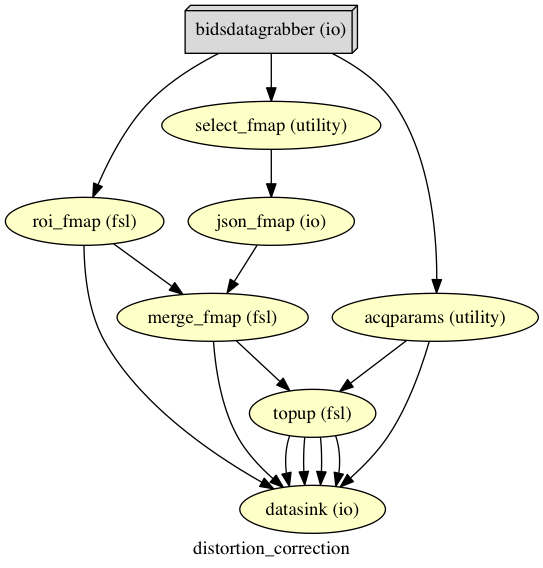

In [469]:
# write the graph
wf.write_graph(graph2use='colored',simple_form=True)
Image(filename=os.path.join(path_target, wf.name, "graph.png"))
# execute the workflow:
# wf.run('MultiProc')